In [20]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import skeletor as sk
from skeletor.data import loadTestDataset
from skeletor.spatial import angularHistogramAroundPoint

#from skeletor.spatial import approxPeakFind
from scipy.signal import find_peaks

from scipy.spatial import KDTree
from pepe.topology import findPeaksMulti, findPeaks1D, findPeaks2D

In [17]:
def spatialClusterLabels(points, l=.001):
    """
    Partition a set of points in clusters, and return the
    cluster label for each point.

    Method is very simplistic: the neighbors (points within
    a threshold distance) of a point are added to the same
    cluster, and the process is repeated until no points
    remain. This means that the size of clusters can be
    larger than this distance threshold (eg. think of a
    chain of points).

    Parameters
    ----------
    points : numpy.ndarray[N,d]
        Array of N points in d-dimensions

    l : float
        Distance threshold to consider two points as being in the
        same cluster. Given as fraction of the total system size.
        
    Returns
    -------
    labels : numpy.ndarray[N]
        Array of N labels (integers) denoting cluster
        assignment. Total number of clusters will be `max(labels)+1`.
    """
    d = np.shape(points)[-1]
    
    systemLengthScale = np.sqrt(np.sum([(np.max(points[:,i]) - np.min(points[:,i]))**2 for i in range(d)]))
    threshold = l*systemLengthScale
    
    # Generate a kd-tree
    kdTree = KDTree(points)

    pointsList = points.tolist()
    randomOrder = np.arange(len(pointsList))
    np.random.shuffle(randomOrder)
    
    labels = np.zeros(len(pointsList)) - 1
    labelsToMerge = []
    
    i = 0
    
    while len(np.where(labels == -1)[0]) > 0:
        # Grab a point, if it doesn't have a group already, create a new one
        if labels[randomOrder[i]] == -1:
            labels[randomOrder[i]] = np.max(labels)+1
        p = pointsList[randomOrder[i]]

        # Find its neighbors
        neighbors = kdTree.query_ball_point(p, r=threshold)

        # neighorLabels = [labels[n] for n in neighors]
        # uniqueNeighborLabels = np.unique(neighborLabels)
        # if len(uniqueNeighborLabels) == 1:
        #     # If all are unlabeled
        #     if uniqueNeighborLabels[0] == -1:
        #         # Create a new group
        #         labels[randomOrder[i]] = np.max(labels)+1

        #     # All are already in another group
        #     else:
        #         # Assign this point to that group as well
        #         labels[randomOrder[i]] = uniqueNeighborLabels[0]
        
        # Assign all of them to be the same group
        for index in neighbors:
            if index == randomOrder[i]:
                continue
                
            # If they already have a label, we will eventually want to merge the labels
            if labels[index] >= 0 and labels[index] != labels[randomOrder[i]]:
                # See if this is already in a merge group
                inGroup = False
                for j in range(len(labelsToMerge)):
                    # If it is already going to be merged, add the
                    # new label to this group
                    if labels[index] in labelsToMerge[j]:
                        inGroup = True
                        # If the new label is not in the merge group, add it
                        if not labels[randomOrder[i]] in labelsToMerge[j]:
                            labelsToMerge[j].append(labels[randomOrder[i]])
                            
                        break
                # If we aren't in a merge group, we should create
                # a new one
                if not inGroup:
                    labelsToMerge.append([labels[index], labels[randomOrder[i]]])
                    
            elif labels[index] == -1:
                labels[index] = labels[randomOrder[i]]
            
        i += 1

    mergedLabels = np.zeros_like(labels) - 1
    
    # Now we have to sort out merged clusters
    labelSets = []
    for i in range(int(np.max(labels))+1):
        # Generate a list of all of the labels that are identified together
        # including this value of i
        allLabels = [i]
        for j in range(len(labelsToMerge)):
            if i in labelsToMerge[j]:
                allLabels += labelsToMerge[j]

        # sort so that way we can do a unique check to remove
        # duplicates
        allLabels = sorted(np.unique(allLabels))
        # Python may automatically collapse the list if it is of length 1,
        # which we don't want.
        labelSets.append([allLabels] if len(allLabels) == 1 else allLabels)

    # Remove duplicate sets, creating disjoint sets of labels
    uniqueSets = np.unique(np.array(labelSets, list))

    # If there are no overlaps, then this above operation will
    # flatten the array to be one dimensional. We can't do anything
    # about that, except to check if it is the case. The good news is
    # that if this is the case, then we already have disjoint sets
    # and we can just immediately return our label array
    if len(np.shape(uniqueSets)) == 1:
        return labels

    # Relabel things with the new disjoint sets
    mergedLabels = np.zeros_like(labels)

    # TODO: Probably a much better way to do this
    for i in range(len(pointsList)):
        for j in range(len(uniqueSets)):
            if labels[i] in uniqueSets[j]:
                mergedLabels[i] = j
                break

    return mergedLabels

def spatialClusterCenters(points, l=.001, return_weights=False):
    """
    Partition a set of points in clusters, and compute the
    center of each cluster.

    Generates clusters using `pepe.topology.spatialClusterLabels()`.

    Parameters
    ----------
    points : numpy.ndarray[N,d]
        Array of N points in d-dimensions

    l : float
        Distance threshold to consider two points as being in the
        same cluster. Given as fraction of the total system size.

    return_weights : bool
        Whether to return the weight -- defined as the fraction of
        points included in that cluster -- alongside the centers.
        
    Returns
    -------
    centers : numpy.ndarray[N, d]
        Array of N points in d-dimensions representing the detected
        clusters in the system.

    weights : numpy.ndarray[N]
        Array of weights -- defined as fraction of all points included
        in each cluster -- for each cluster. Only returned if
        `return_weights=True`.

    """
    labels = spatialClusterLabels(points, l=l)
    numLabels = int(np.max(labels))+1
    
    # Compute the center of each cluster
    weights = np.zeros(numLabels)
    centers = np.zeros((numLabels, np.shape(points)[-1]))
    
    for i in range(numLabels):
        indices = np.where(labels == i)
        centers[i] = np.mean(np.array(points)[indices], axis=0)
        weights[i] = len(indices[0])/len(labels)

    order = np.argsort(weights)[::-1]
    centers = centers[order]
    weights = weights[order]
    
    if return_weights:
        return centers, weights
        
    return centers

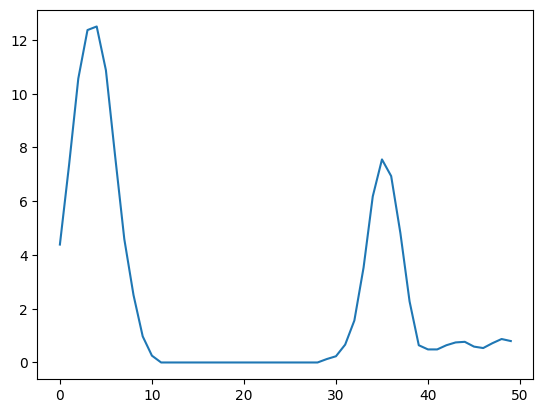

In [2]:
# Some data to test on
points = loadTestDataset('2d_curve_2', extraNoise=.02)
testPoint = 25
neighborDistance = 0.1

hist, axes = angularHistogramAroundPoint(points, testPoint, neighborDistance=neighborDistance)

plt.plot(hist)
plt.show()

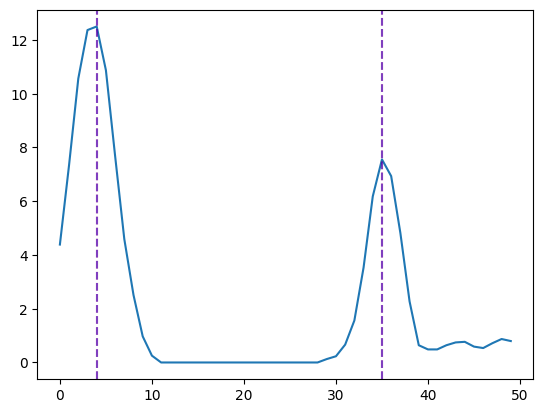

In [3]:
peaks = find_peaks(hist, prominence=0.5)[0]
approxPeaks, prevalences = findPeaks1D(hist, minPeakPrevalence=.1, periodic=False)

plt.plot(hist)
for i in peaks:
    plt.axvline(i, linestyle='--', c='red', alpha=.5)

for i in approxPeaks:
    plt.axvline(i, linestyle='--', c='blue', alpha=.5)

plt.show()

In [8]:
np.array([1, 2, 3]) % np.array([2, 2, 3])

array([1, 0, 0])

In [4]:
%timeit findPeaks1D(hist, minPeakPrevalence=0.6)
%timeit findPeaksMulti(hist, minPeakPrevalence=0.6)

3.66 µs ± 75.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
1.4 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


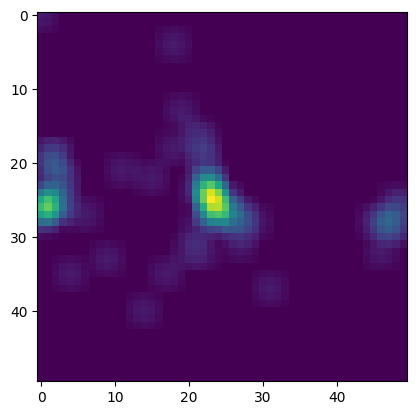

In [5]:
# Some data to test on
points = loadTestDataset('wireframe_cube_1', extraNoise=.005)
testPoint = 100
neighborDistance = 0.1

hist, axes = angularHistogramAroundPoint(points, testPoint, neighborDistance=neighborDistance)

plt.imshow(hist)
plt.show()

(165, 2)


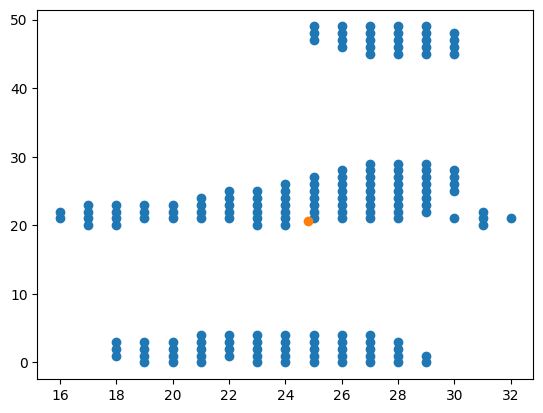

In [26]:
points = np.array(np.where(hist > 4*np.mean(hist))).T
print(points.shape)
centers = spatialClusterCenters(points, l=1)
plt.scatter(*points.T)
plt.scatter(*centers.T)
plt.show()

array([[24.79393939, 20.58787879]])

In [14]:
??spatialClusterCenters

Signature:
spatialClusterCenters(
    points,
    l=0.001,
    randomize=False,
    wrapPoints=None,
    pointWeights=None,
    return_weights=False,
)
Docstring:
Partition a set of points in clusters, and compute the
center of each cluster.

Generates clusters using `pepe.topology.spatialClusterLabels()`; see
this method for more information.

Parameters
----------
points : numpy.ndarray[N,d]
    Array of N points in d-dimensions

l : float
    Distance threshold to consider two points as being in the
    same cluster. Given as fraction of the total system size.

randomize : bool
    The clustering processes is dependent on the order of
    the points; if `randomOrder=True`, the provided array will
    be indexed in a random order, otherwise it will be accessed
    exactly as provided. 
    
    See documentation for `pepe.topology.spatialClusterLabels()`.

wrapPoints : numpy.ndarray[d] or float or None
    If the space is periodic, the size of each dimension. If
    a single value is

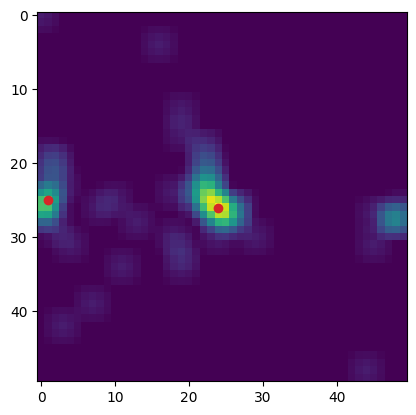

In [26]:
peaks, prevalences = findPeaks2D(hist, minPeakPrevalence=.6, periodic=False)

plt.imshow(hist)
plt.scatter(*peaks.T[::-1], c='tab:red')
plt.show()

In [14]:
%timeit findPeaks2D(hist, minPeakPrevalence=0.6)
%timeit findPeaksMulti(hist, minPeakPrevalence=0.6)
%timeit approxPeakFind(hist)

7.2 ms ± 94.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.64 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
36.8 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
findPeaksMulti(hist, minPeakPrevalence=0.6, allowOptimize=True)

(array([[23, 38],
        [24, 12],
        [17, 13],
        [15, 36]]),
 array([1.        , 0.83808804, 0.77010773, 0.61665815]))